In [45]:
import pandas as pd
import numpy as np
import keras
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.model_selection import train_test_split
import pickle
%matplotlib inline

%load_ext autoreload
%autoreload 2
import helper

Fasttext facebook
PubMed PMC word vectors
Gensim word2vec

In [2]:
df = pd.read_csv("data/train_binary.csv")

In [3]:
df.head()

,Id,Title,Abstract,Category
0,746,SHP2 promotes laryngeal cancer growth through ...,The overall survival rate and prognosis of pat...,cancer
1,421,Response to Crizotinib Observed in Lung Adenoc...,MMNG HOS Transforming gene (MET) is an importa...,cancer
2,261,Genome-wide profiling of genetic synthetic let...,"Small-molecule inhibitors of PARP1/2, such as ...",cancer
3,644,MMP2 and MMP9 serum levels are associated with...,Addition of bevacizumab to trastuzumab-based n...,cancer
4,1495,Src Family Kinases Modulate the Loss of Endoth...,Activation of Src Family Kinase (SFK) signalin...,nonCancer


In [4]:
target = pd.get_dummies(df["Category"])["cancer"]
documents = df["Abstract"]

# TfIdf-BoW model

In [92]:
count_vect = CountVectorizer(binary=False, max_df=0.9, min_df=3, lowercase=True, strip_accents="unicode")
count_vect.fit(documents)
pickle.dump(count_vect, open("vectorizer.p", "wb"))
X_train_counts = count_vect.transform(documents)
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X_train_counts)
X.shape

(2155, 8069)

# Basic Keras model

In [46]:
from keras.layers import Dense, Dropout

In [50]:
def create_model():
    model = keras.models.Sequential()
    model.add(Dense(16, input_shape=(X.shape[1],), activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [51]:
acc = []
for i in range(10):
    print("Loop {}".format(str(i)))
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.1)
    model = create_model()
    model.fit(X_train.todense(), y_train, validation_split=0.1, epochs=20, verbose=0)
    yhat = model.predict(X_test.todense())
    acc_i = helper.score_prediction(y_test, yhat, acc_only=True)
    acc.append(acc_i)

print("Average Accuracy: {:.2%}".format(np.mean(acc)))
print(acc)

Loop 0
Loop 1
Loop 2
Loop 3
Loop 4
Loop 5
Loop 6
Loop 7
Loop 8
Loop 9
Average Accuracy: 95.69%
[0.96759259259259256, 0.95833333333333337, 0.96296296296296291, 0.95370370370370372, 0.94907407407407407, 0.96759259259259256, 0.97222222222222221, 0.94907407407407407, 0.93055555555555558, 0.95833333333333337]


             precision    recall  f1-score   support

          0       0.95      1.00      0.98       103
          1       1.00      0.96      0.98       113

avg / total       0.98      0.98      0.98       216

Accuracy: 97.69%
AUC: 1.0


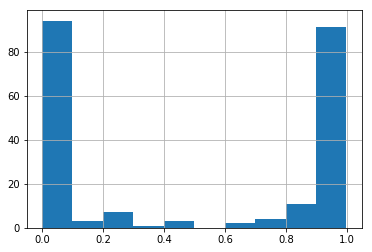

In [22]:
yhat = model.predict(X_test.todense())
helper.score_prediction(y_test, yhat)

# Feed Forward with embedding layer

In [121]:
from keras.layers import Embedding, Conv1D, GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

In [19]:
import gensim

In [52]:
stoplist = list(gensim.parsing.preprocessing.STOPWORDS) + ["<span"] + list(range(0,9))
def word_is_valid(word):
    return word not in stoplist and len(word) > 2 and len(word) < 20

texts = [[word for word in document.lower().split() if word_is_valid(word)] for document in documents]

In [53]:
dictionary = gensim.corpora.Dictionary(texts)
print(dictionary)
dictionary.filter_extremes(no_above=0.9, no_below=5)
print(dictionary)

Dictionary(48814 unique tokens: ['sym004,', 'compliance,', 'inversions,', '5b,', '584']...)
Dictionary(6255 unique tokens: ['follow-up', 'conditions,', 'analytic', 'register', 'progression']...)


In [54]:
token2id = dictionary.token2id

In [55]:
corpus = [[token2id.get(word) for word in text if token2id.get(word, False)] for text in texts]

In [62]:
maxlen = 1000
X_sequential = sequence.pad_sequences(corpus, maxlen=maxlen)

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X_sequential, target.values, test_size=0.1)

In [126]:
def create_embedding_ff_model():
    embedding_dim = 100
    filters = 250
    kernel_size = 3
    model = keras.models.Sequential()
    model.add(Embedding(input_dim=len(token2id), output_dim=embedding_dim, input_length=maxlen))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
    # we use max pooling:
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [127]:
model = create_embedding_ff_model()
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, validation_split=0.1, epochs=20, batch_size=256)

Train on 1745 samples, validate on 194 samples
Epoch 1/20
1745/1745 [==============================] - 62s - loss: 0.6786 - acc: 0.5696 - val_loss: 0.6214 - val_acc: 0.7732
Epoch 2/20
1745/1745 [==============================] - 61s - loss: 0.5272 - acc: 0.8774 - val_loss: 0.4028 - val_acc: 0.9278
Epoch 3/20
1745/1745 [==============================] - 60s - loss: 0.3186 - acc: 0.9203 - val_loss: 0.2486 - val_acc: 0.9330
Epoch 4/20


KeyboardInterrupt: 

             precision    recall  f1-score   support

          0       0.99      0.87      0.93       108
          1       0.88      0.99      0.93       108

avg / total       0.94      0.93      0.93       216

Accuracy: 93.06%
AUC: 0.97


0.93055555555555558

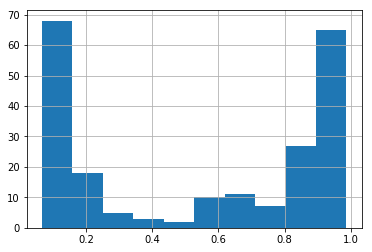

In [129]:
yhat = model.predict(X_test)
helper.score_prediction(y_test, yhat)